In [66]:
#Importing all the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
import statsmodels.api as sm
import itertools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, RocCurveDisplay
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from FraminghamDataCleaning import FraminghamDataCleaning

In [67]:
cleaner = FraminghamDataCleaning()

# Exploratory Analysis

## Nulls/Descriptive Statistics

In [68]:
#read in the file
df = pd.read_csv('framingham_heart_study.csv')

-------------------- Data Shape --------------------
(4240, 16)

-------------------- Data Head --------------------
   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4            

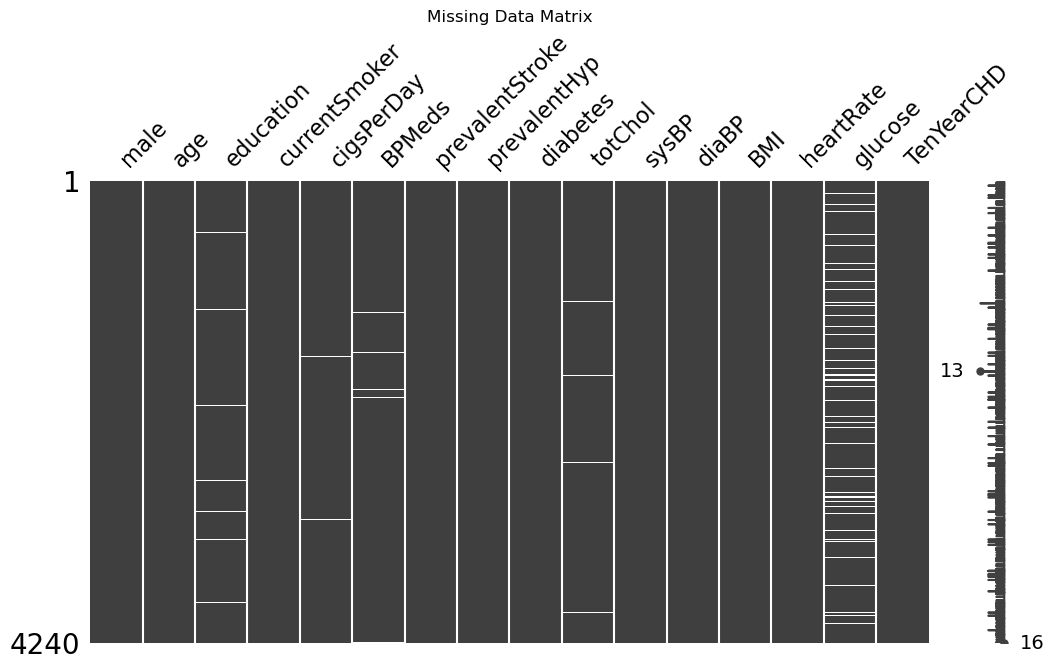


-------------------- Data Info --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: floa

In [69]:
#exploring the file
cleaner.explore_data(df)

### Take Aways
#### Nulls
* Education, CigsPerDay, BPMeds, totChol, BMI, HeartRate, and Glucose all have nulls values
* Glucose has the most nulls (388 records) and is ~9% of the total data

#### Imputation
* Categorical values are luckily already imputed (i.e. Gender is binary 0 = Female, 1= Male)
* Need to be careful with imputing CigsPerDay. We don't want to have a non-smoker accidentally imputed as smoking cigs
* Median may be best to impute due to outliers (see below)

#### Statistic/Distribution
* Still need to check for outliers/distribution of the numerical values like BMI, Glucose
* Most Column Statistics seems reasonable. No flags like 999 or negatives like -1.
* Cholestrol has outlier. High cholestrol is 240 mg/dL or higher. Max of 696 is unreasonable. Less than 200 is optimal
* sysBP has outlier. Over 180 mmHg is hypertension crisis. Max of 295 is unreasonable. Below 180 acceptable
* diaBP has outlier. Over 120 mmHg is hypertension crisis. Max of 142 is unreasonable. Below 120 acceptable
* BMI has outlier. Over 35 is extremely obese. Max of 56 is unreasonable.  Underweight is less than 18.5. Min of 15 seems unreasonable. 18.5 to 35 is acceptable.
* HeartRate has outlier. A normal resting heart rate for adults ranges from 60 to 100 bpm. Well trained athlete around 40. Max of 143 is unreasonable
* Glucose has outliers. Normal fasting glucose levels are 80-100. Min Glucose level of 40 seems too low and max of 394 seems way too high even after eating a meal

![Alt Text](https://media.post.rvohealth.io/wp-content/uploads/2024/07/3707552-UPDATE-Blood-Pressure-Ranges.png)
![Alt Text](https://blog.medkart.in/wp-content/uploads/2024/01/Normal-Blood-Sugar-Levels-Chart.jpg)

## Visualize Fields Before Cleaning/Imputing

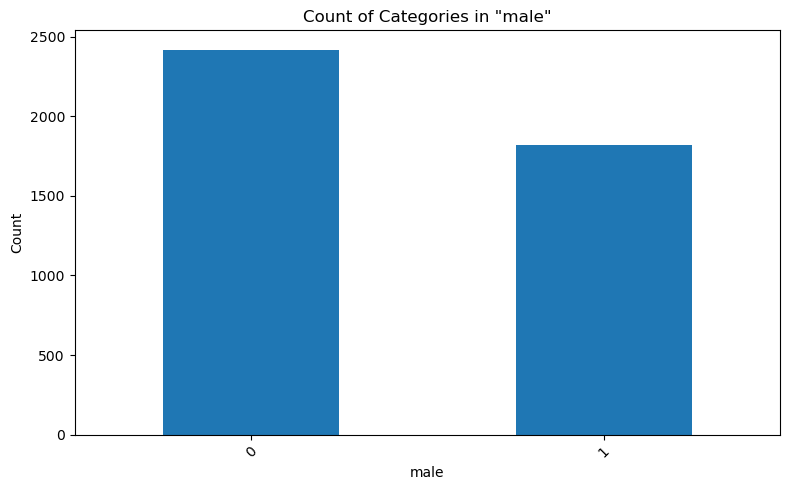

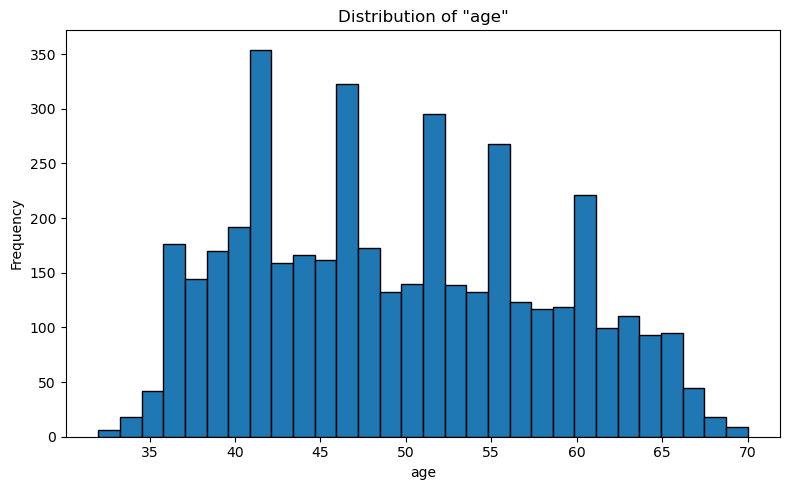

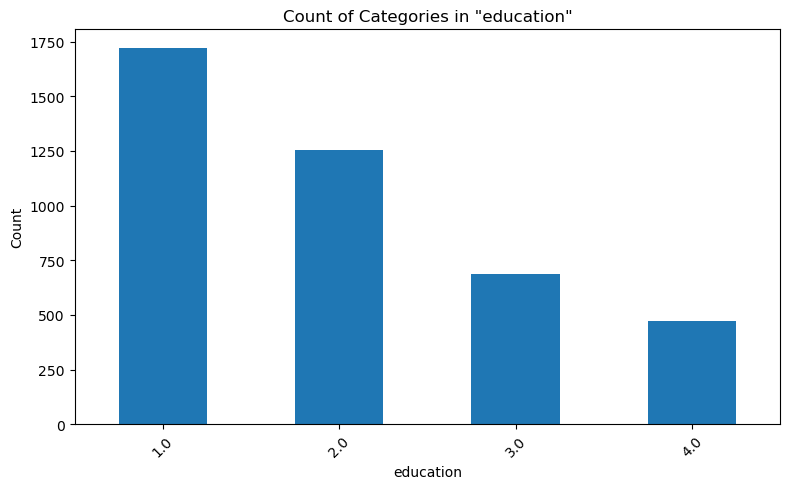

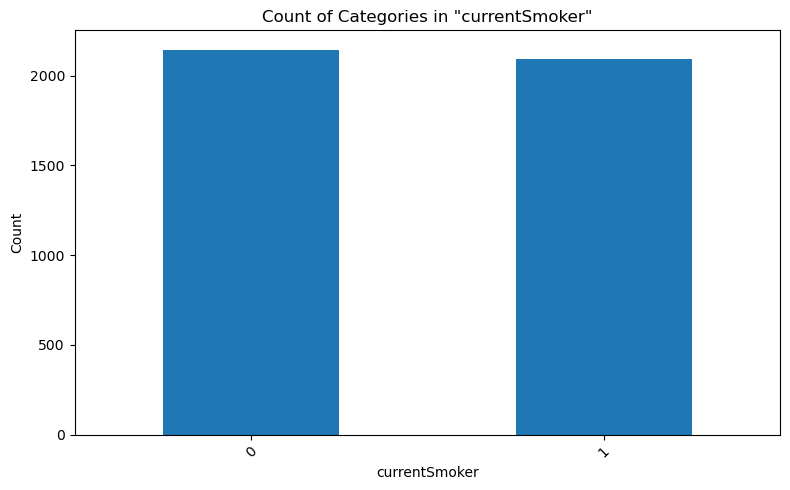

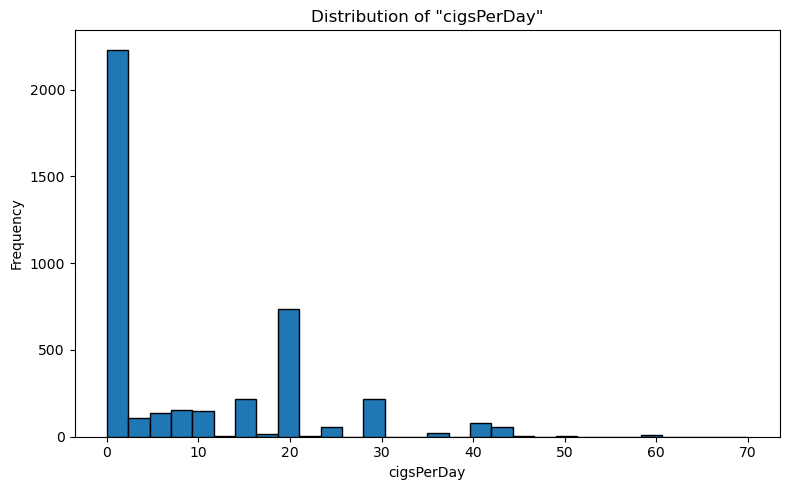

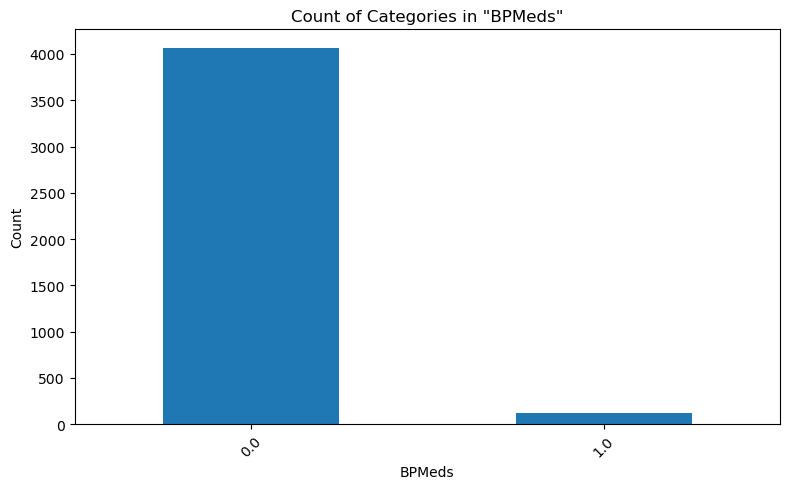

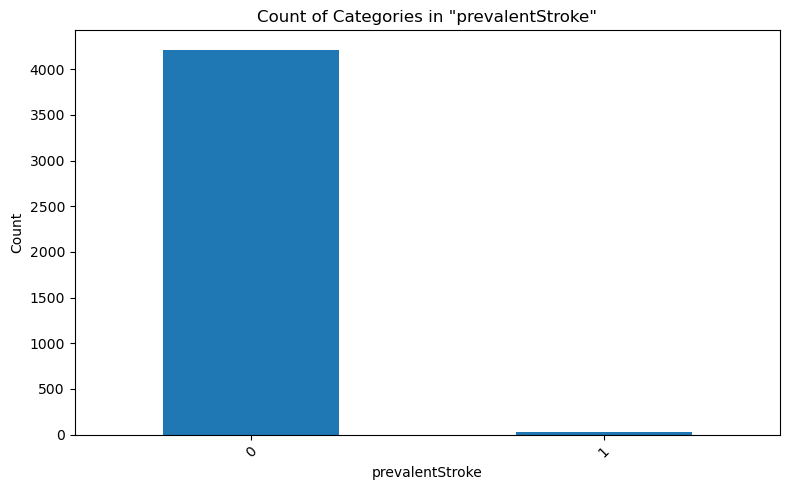

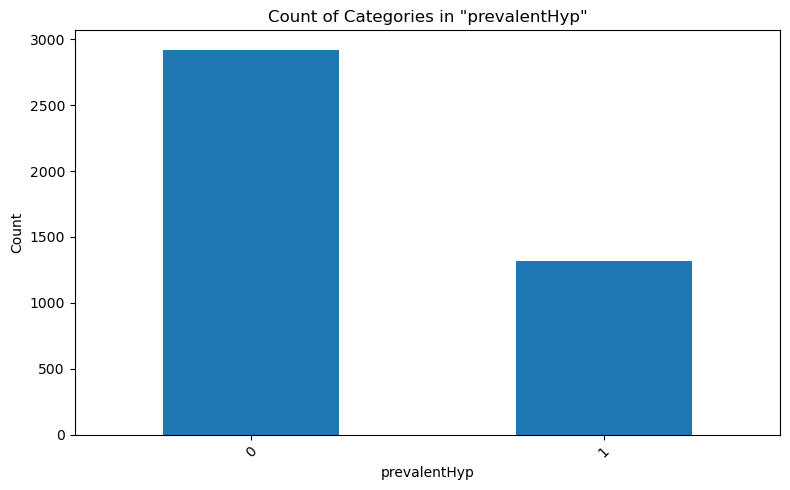

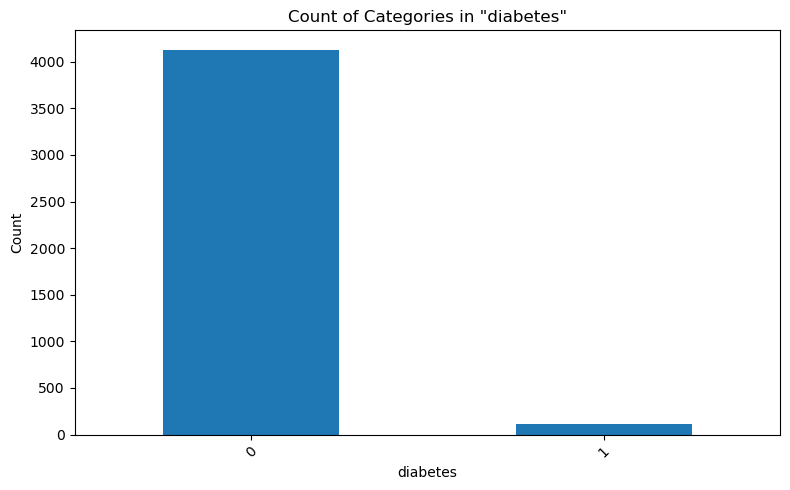

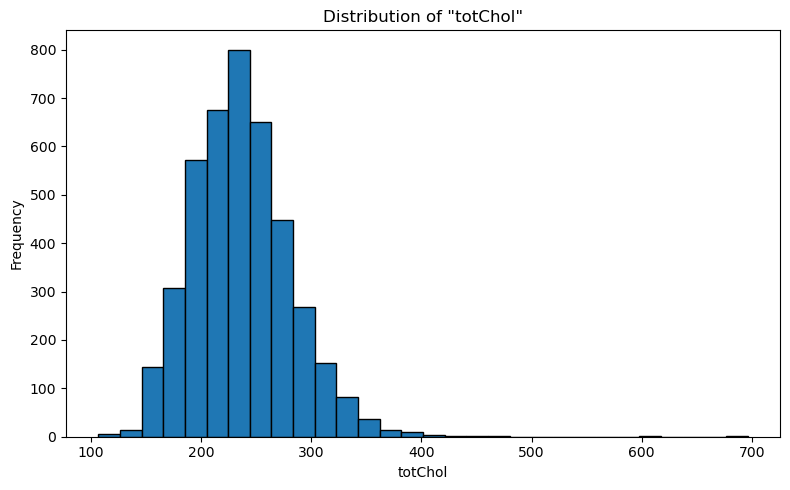

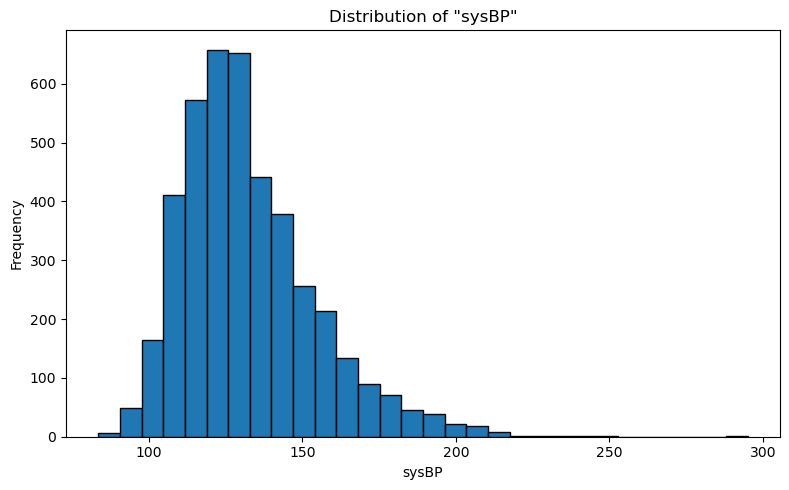

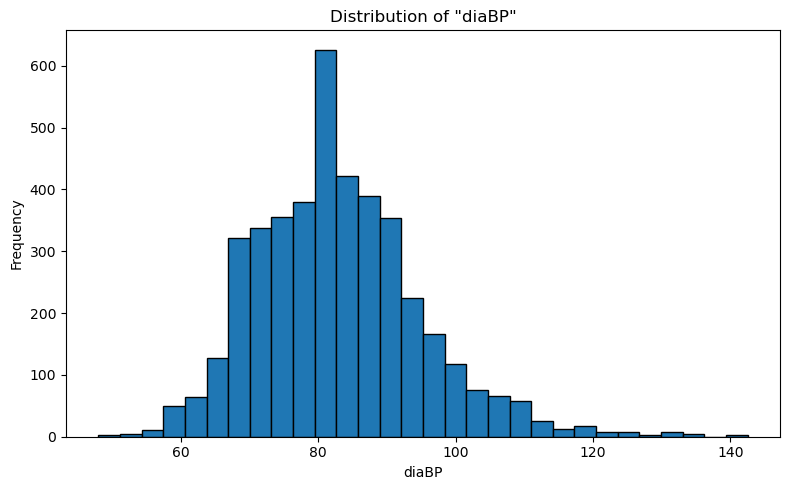

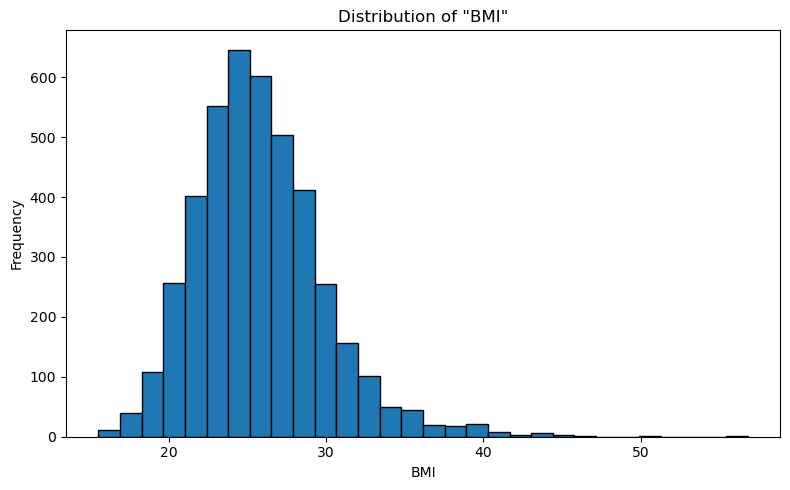

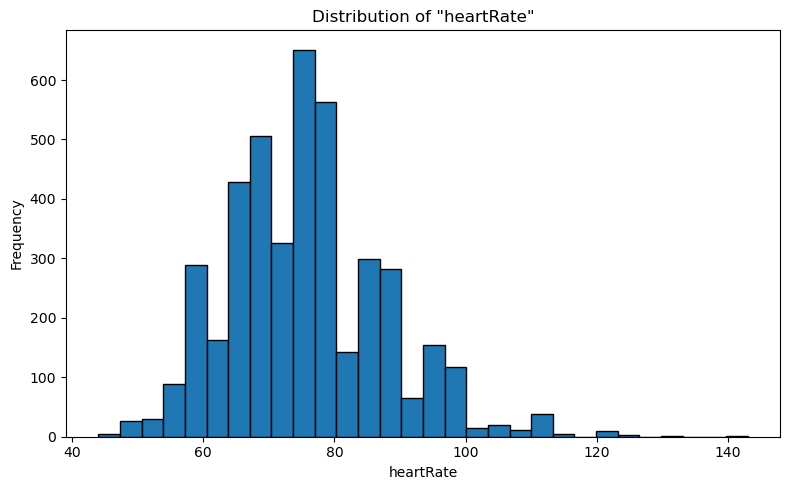

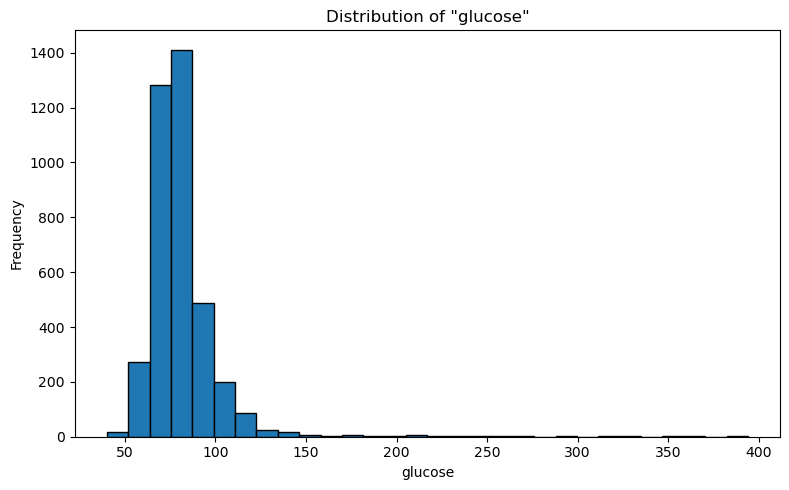

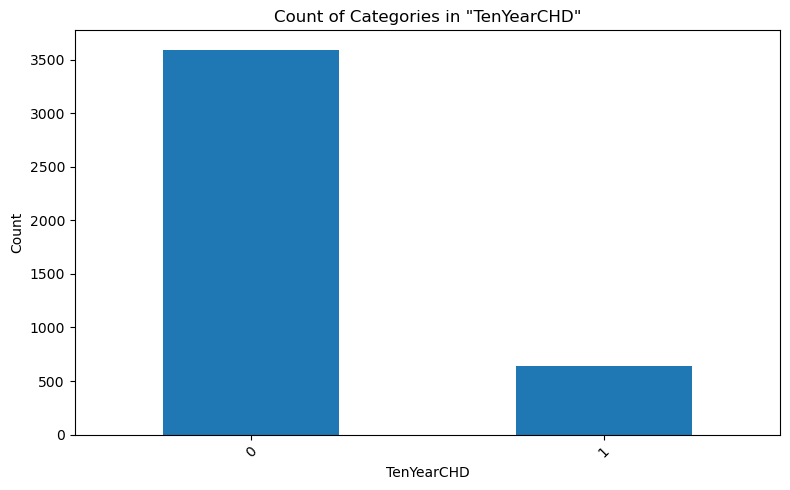

In [70]:
# Visualizing the fields before we do anything
cleaner.plot_all_columns(df)

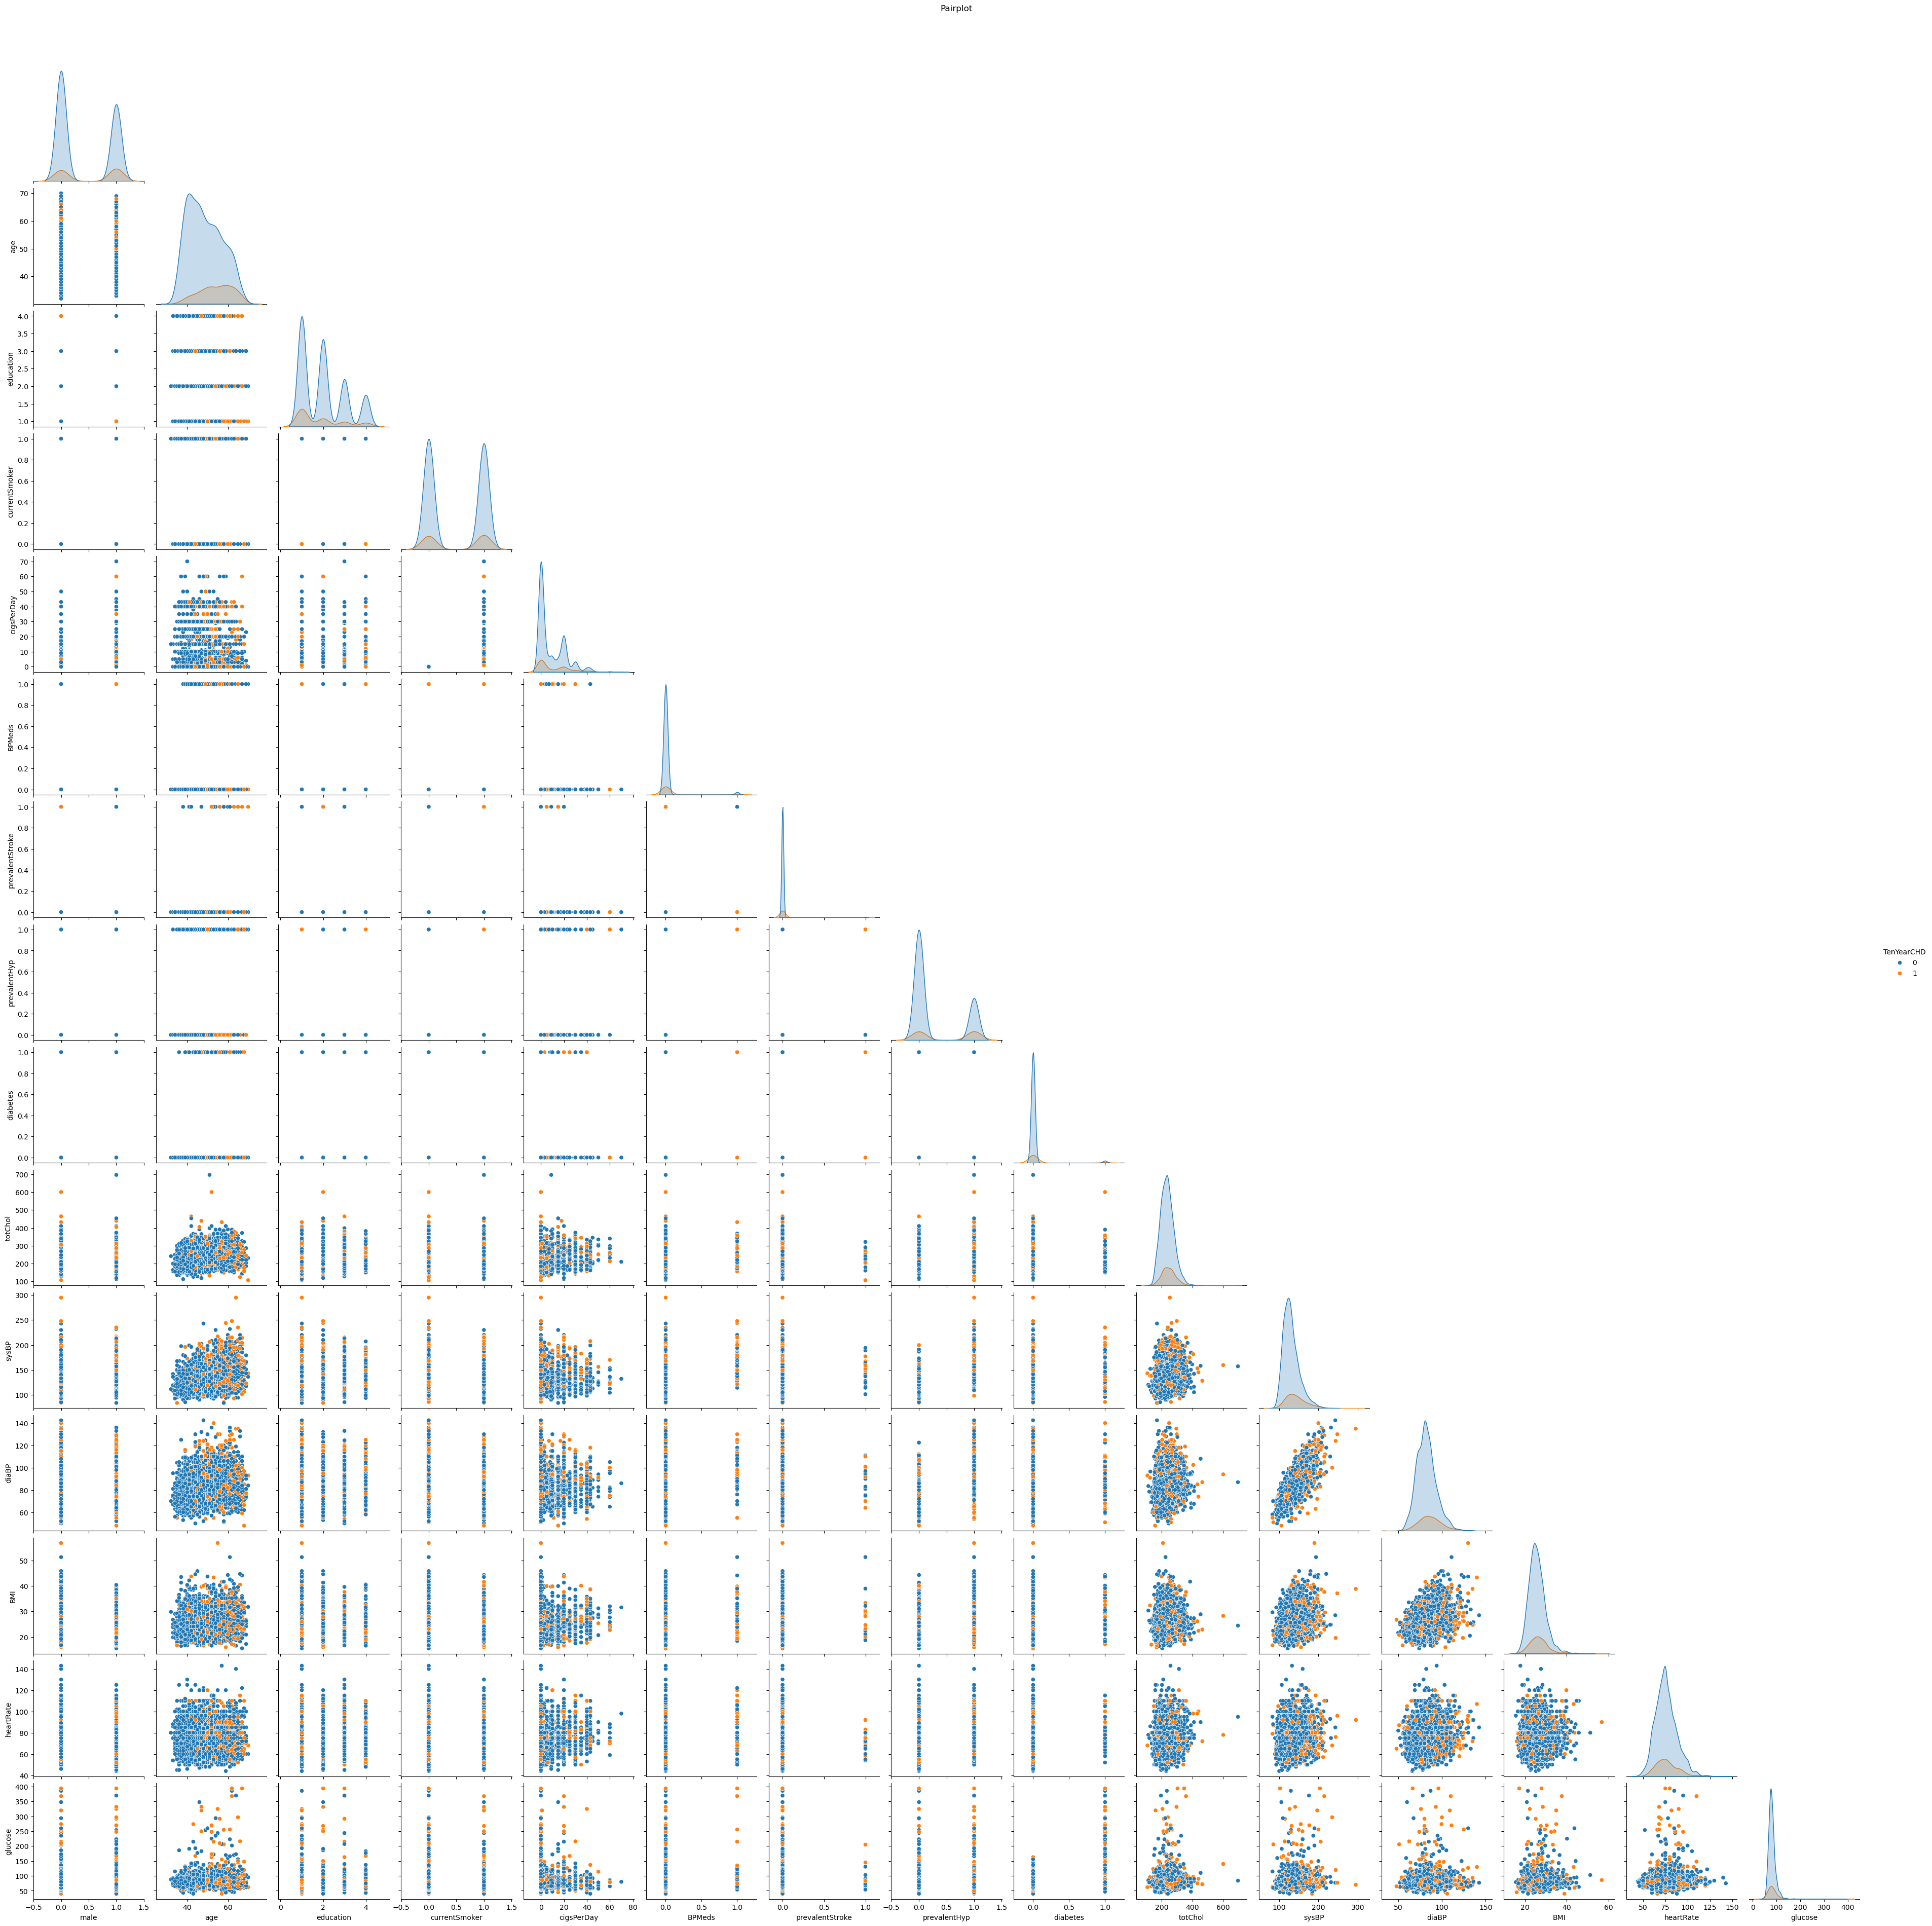

In [71]:
# Checking the pairplots before we do anything
cleaner.visualize_data(df=df, target_col='TenYearCHD')

### Take Aways
#### Features
* Since the numeric data like BMI is skewed right, we'll use the median to impute the nulls. Then we'll need to eliminate outliers. 
* Only education was the only 'categorical' (ordinal) variable that had null. We'll use the mode to impute since 1 indicates lower education anyway and we can't assume they were educated. 
* There might be some multicollinearity/association between diaBP and sysBP. Look into after imputation

#### Target Variable (TenYearCHD)
* The target variable is heavily imbalanced in which there are significantly more cases of not having CHD compared to having CHD. We'll most likely use SMOTE



# Data Cleaning

## Imputation

In [72]:
# Impute nulls using class logic
df_imputed = cleaner.impute_nulls(df)

c:\Users\Chris Napoli\OneDrive\Desktop\Analytics With ML\Final Project Repo\ProjectHawk2025\FraminghamDataCleaning.py:106: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)
c:\Users\Chris Napoli\OneDrive\Desktop\Analytics With ML\Final Project Repo\ProjectHawk2025\FraminghamDataCleaning.py:119: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will neve

-------------------- Data Shape --------------------
(4240, 16)

-------------------- Data Head --------------------
   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4            

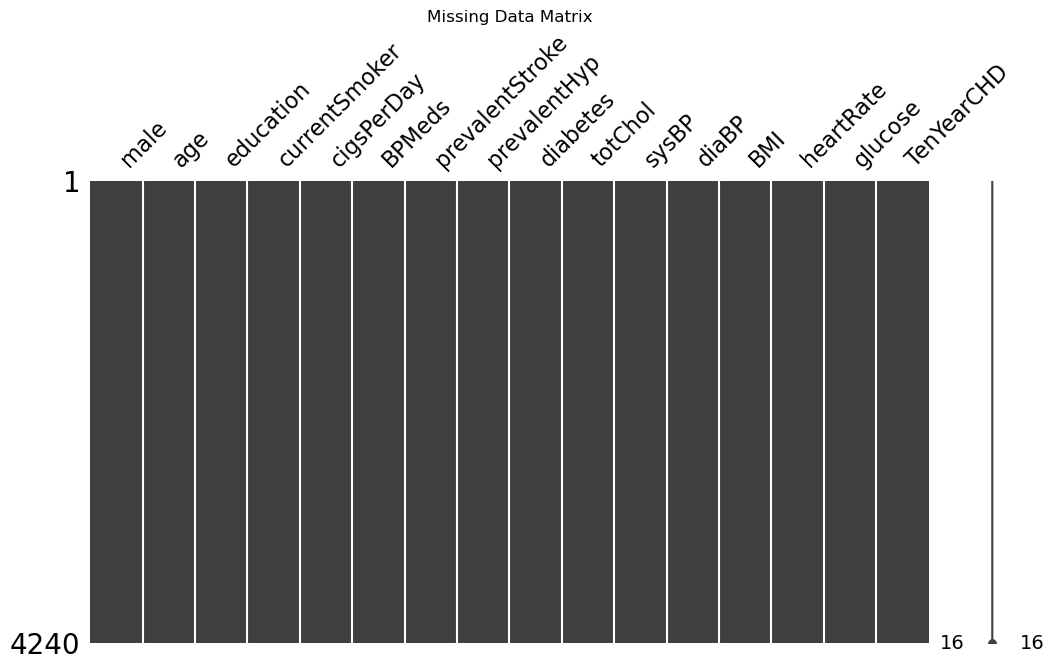


-------------------- Data Info --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4240 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4240 non-null   float64
 5   BPMeds           4240 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4240 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4240 non-null   float64
 13  heartRate        4240 non-null   float64
 14  glucose          4240 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: floa

In [73]:
# All nulls have been imputed
cleaner.explore_data(df_imputed)

### Take Aways
#### Imputing Nulls
* 'Education' was imputed using the mode (1 = Least Education). This makes sense since we can't really assume nulls are highly educated so the least education option makes the most sense. 
* 'cigsPerDay' was imputed using the dependency of 'currentSmoker'. If patient DOESN'T smoke and 'cigsPerDay' is null, then impute 0 since they don't smoke. If the patient DOES smoke, impute the median of JUST the smokers. 
* the rest of the columns like 'BMI', 'sysBP', 'glucose', etc were all slightly skewed right, so the median was used to impute. 
* The dataframe used going forward should be df_imputed since imputation was done. 


## Outlier Handling

In [74]:
# Remember we need to remove the encoded categorical variables. We just want the numerical columns to inspect outliers
columns_cat = [
    'male', 'education', 'currentSmoker',
    'diabetes', 'prevalentHyp', 'prevalentStroke','BPMeds', 'TenYearCHD'
]

df_reduced = df_imputed.drop(columns=columns_cat)

In [75]:
df_reduced

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,39,0.0,195.0,106.0,70.0,26.97,80.0,77.0
1,46,0.0,250.0,121.0,81.0,28.73,95.0,76.0
2,48,20.0,245.0,127.5,80.0,25.34,75.0,70.0
3,61,30.0,225.0,150.0,95.0,28.58,65.0,103.0
4,46,23.0,285.0,130.0,84.0,23.10,85.0,85.0
...,...,...,...,...,...,...,...,...
4235,48,20.0,248.0,131.0,72.0,22.00,84.0,86.0
4236,44,15.0,210.0,126.5,87.0,19.16,86.0,78.0
4237,52,0.0,269.0,133.5,83.0,21.47,80.0,107.0
4238,40,0.0,185.0,141.0,98.0,25.60,67.0,72.0


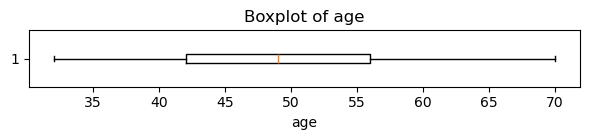

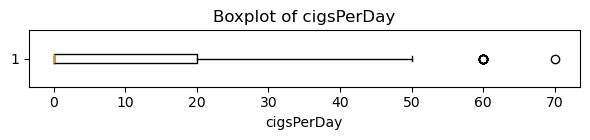

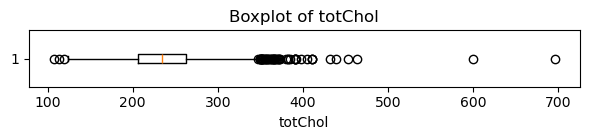

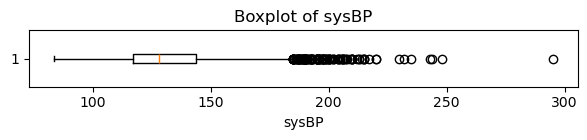

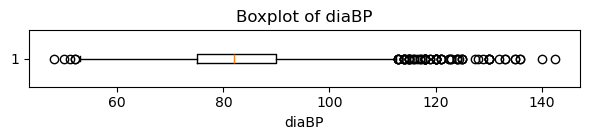

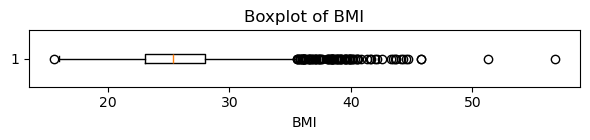

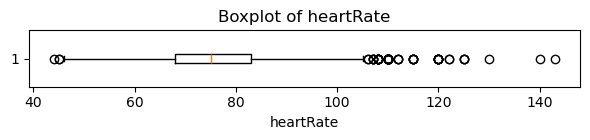

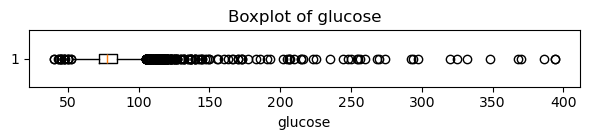


Summary:
Total rows with at least one outlier: 581
If removed, rows removed: 581
Percentage of total records that could potentially be removed: 13.70%


,column,num_outliers,percent_outliers
0,age,0,0.00
1,cigsPerDay,12,0.28
2,totChol,57,1.34
3,sysBP,126,2.97
4,diaBP,77,1.82
5,BMI,97,2.29
6,heartRate,76,1.79
7,glucose,262,6.18


In [76]:
# Let's look at the outliers for the numerical columns
cleaner.detect_and_report_outliers(df_reduced)

In [77]:
# Before removing the outliers, check to see where they come from. 
# We'll say yes, it is ok to remove the outliers
df_cleaned = cleaner.review_and_remove_outliers(columns_cat,df_imputed)
df_cleaned


Outliers detected (rows affected):
 - age: 0 records
 - cigsPerDay: 12 records
 - totChol: 57 records
 - sysBP: 126 records
 - diaBP: 77 records
 - BMI: 97 records
 - heartRate: 76 records
 - glucose: 262 records

Total records to be removed: 581 (13.70% of dataset)
581 records removed. Remaining: 3659


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,0.0,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,78.0,0
4238,1,40,3.0,0,0.0,0.0,0,1,0,185.0,141.0,98.0,25.60,67.0,72.0,0


### Take Aways
#### Removing Outliers
* Removing 13.7% of the data may seem too high but it looks like most of the outliers are from glucose column. Removing these outliers does make sense since glucose over 200 is extremely high even for a diabetic when looking at the chart from before
* It seems wrong to impute median for outliers since we'd be adjusting medical records. 
* df_clean should be used going forward

## Visualize After Cleaning

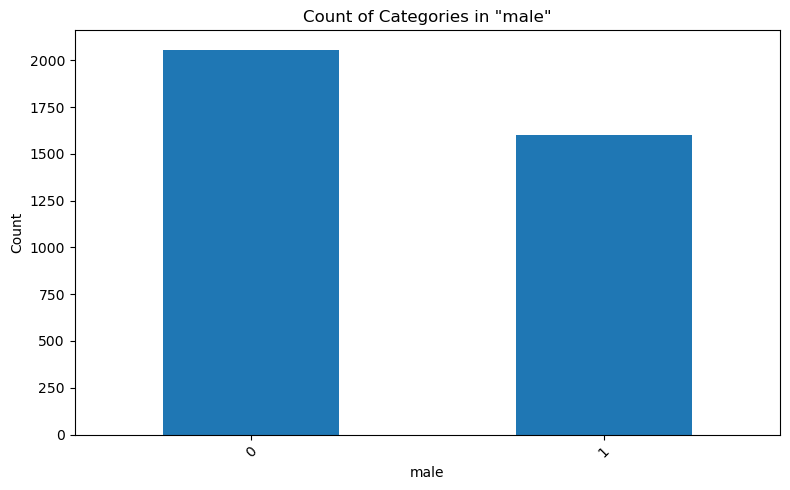

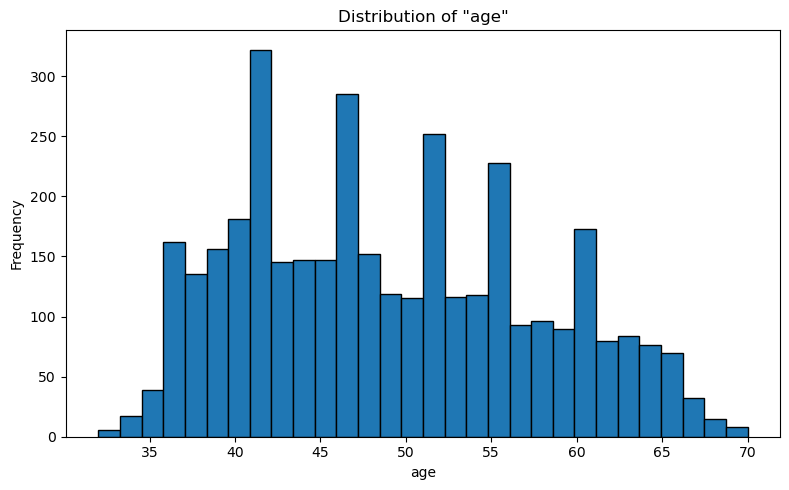

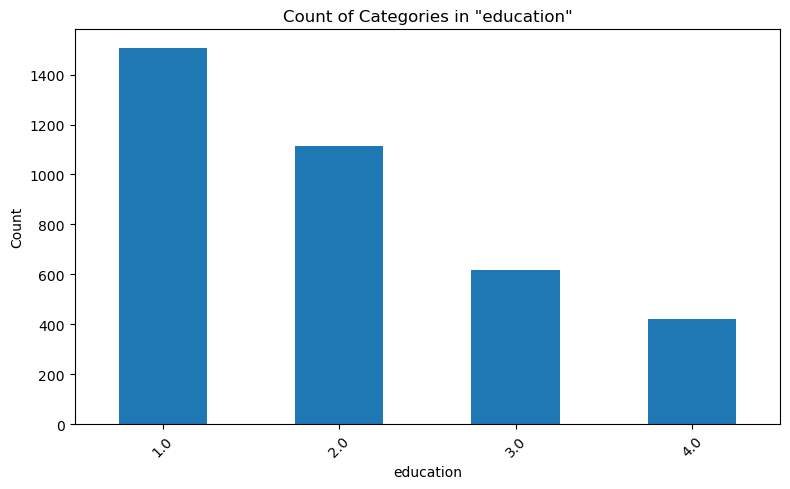

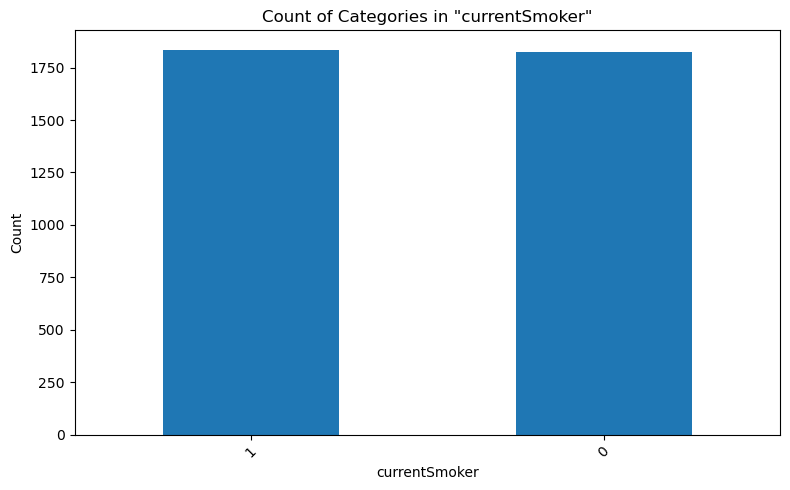

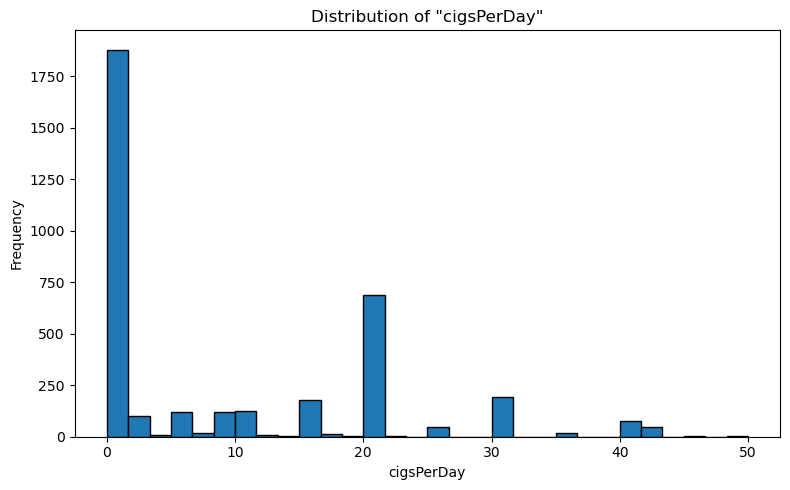

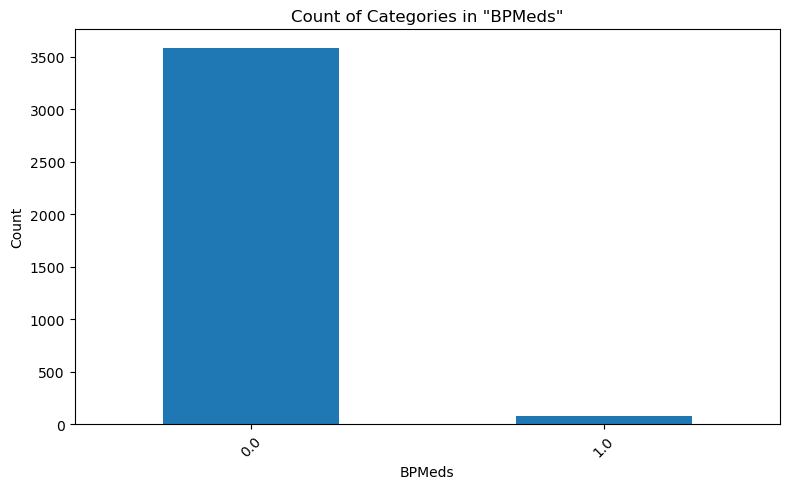

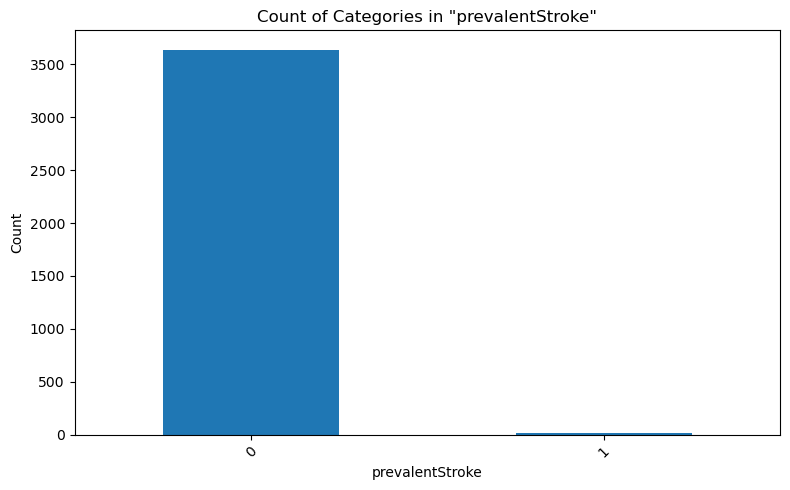

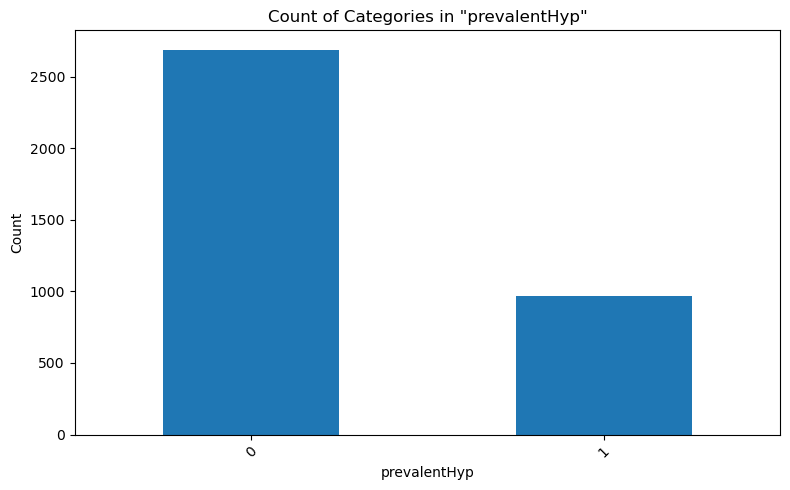

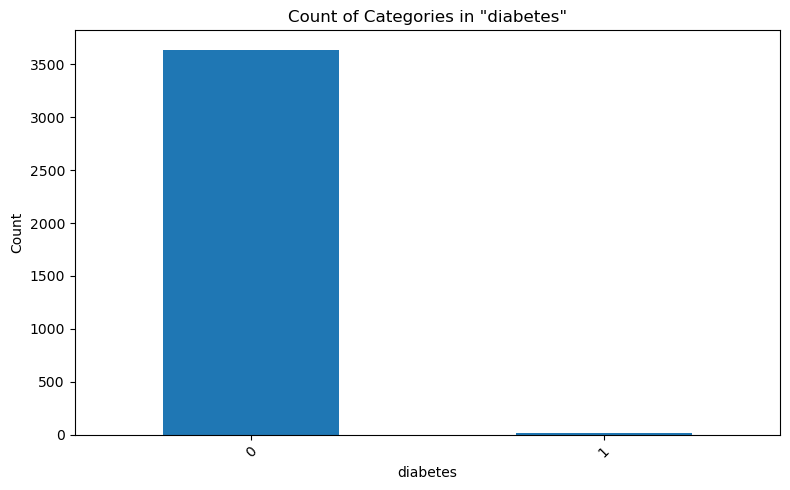

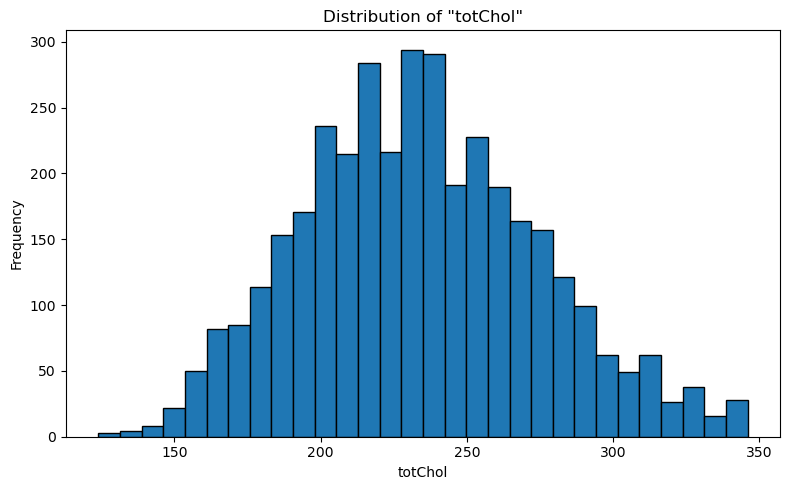

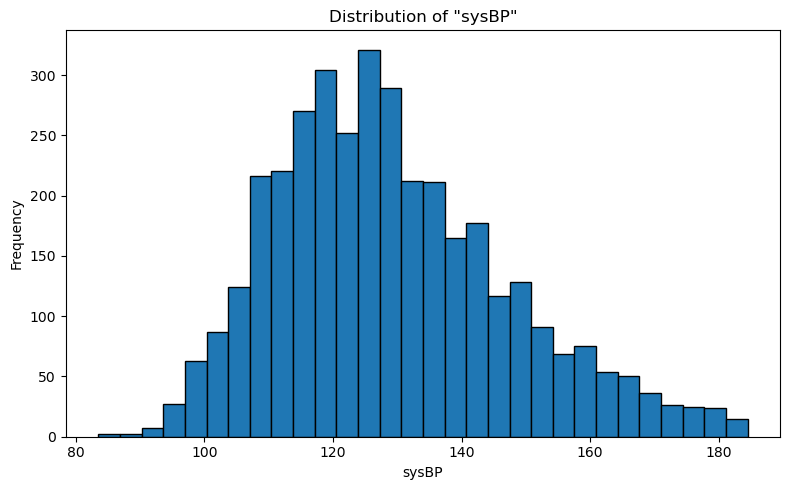

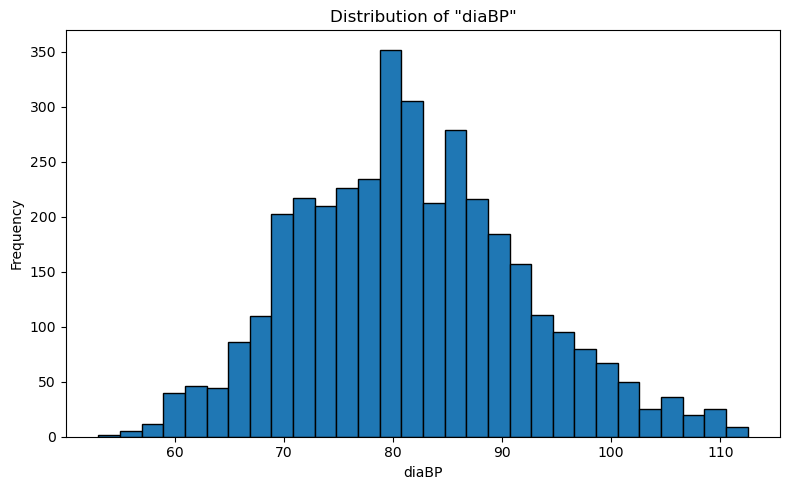

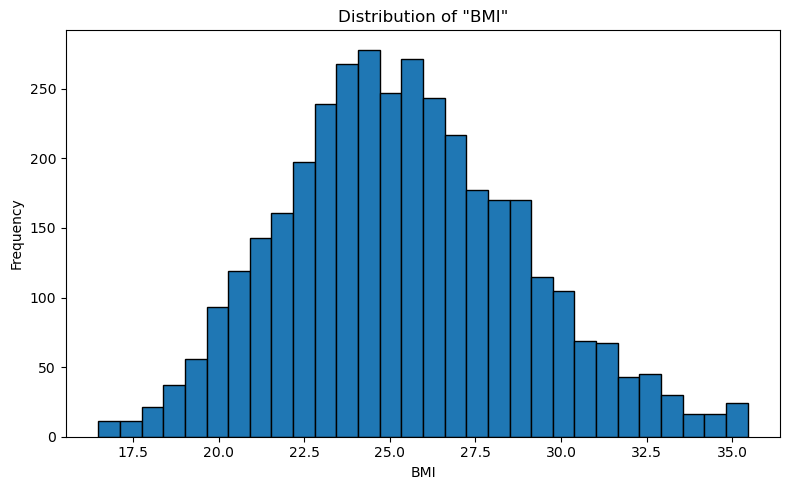

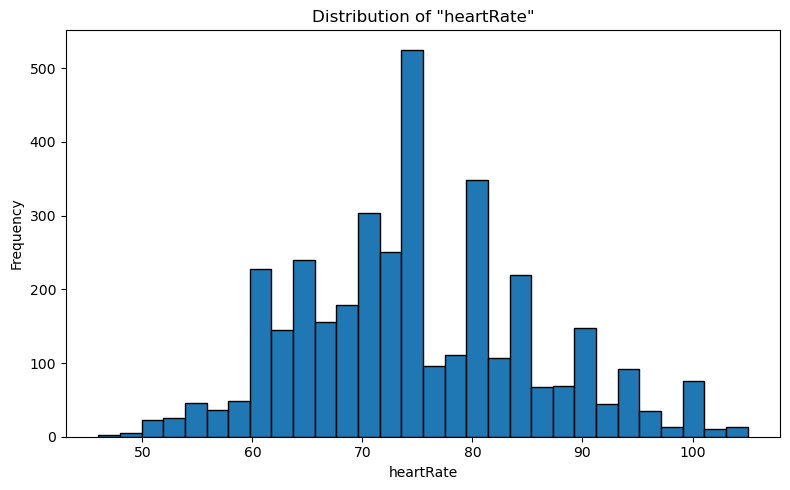

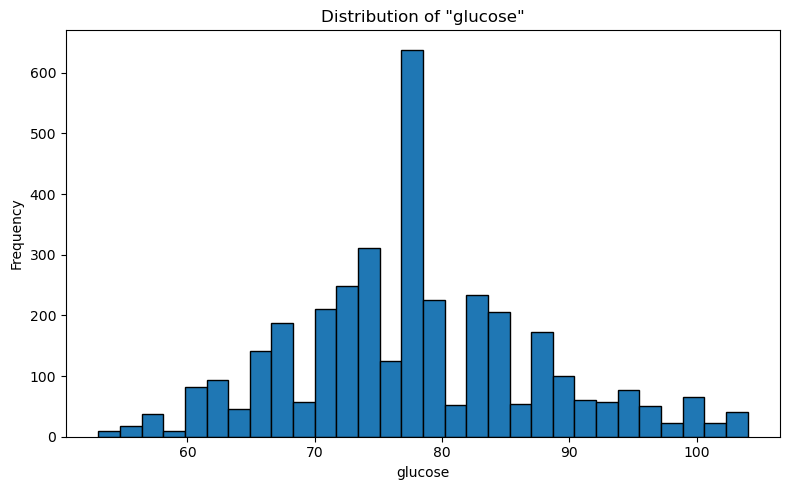

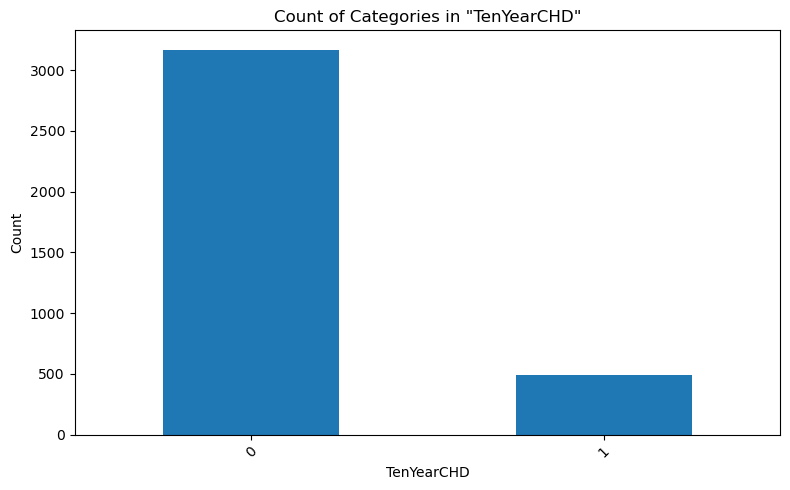

In [78]:
# visualizing the clean data
cleaner.plot_all_columns(df_cleaned)

-------------------- Data Shape --------------------
(3659, 16)

-------------------- Data Head --------------------
   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4            

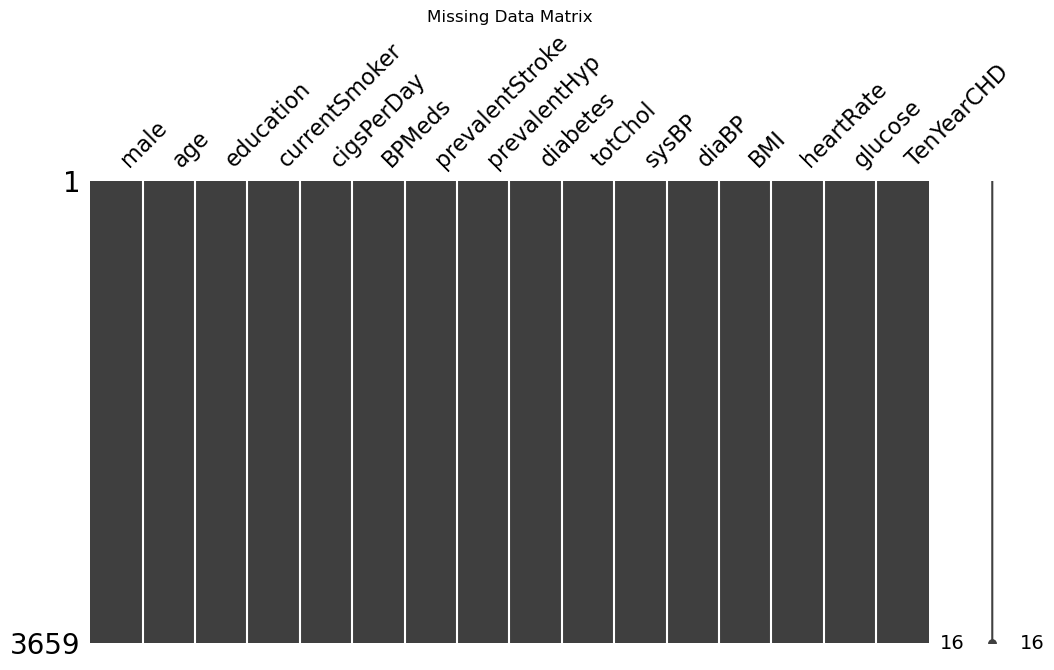


-------------------- Data Info --------------------
<class 'pandas.core.frame.DataFrame'>
Index: 3659 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             3659 non-null   int64  
 1   age              3659 non-null   int64  
 2   education        3659 non-null   float64
 3   currentSmoker    3659 non-null   int64  
 4   cigsPerDay       3659 non-null   float64
 5   BPMeds           3659 non-null   float64
 6   prevalentStroke  3659 non-null   int64  
 7   prevalentHyp     3659 non-null   int64  
 8   diabetes         3659 non-null   int64  
 9   totChol          3659 non-null   float64
 10  sysBP            3659 non-null   float64
 11  diaBP            3659 non-null   float64
 12  BMI              3659 non-null   float64
 13  heartRate        3659 non-null   float64
 14  glucose          3659 non-null   float64
 15  TenYearCHD       3659 non-null   int64  
dtypes: float64(9

In [79]:
# Summary statistic are more reasonable compared to before cleaning
cleaner.explore_data(df_cleaned)

Correlation Matrix:
                 age  cigsPerDay   totChol     sysBP     diaBP       BMI  \
age         1.000000   -0.183239  0.272683  0.370450  0.177990  0.131105   
cigsPerDay -0.183239    1.000000 -0.022110 -0.062494 -0.043401 -0.083950   
totChol     0.272683   -0.022110  1.000000  0.202405  0.186497  0.159296   
sysBP       0.370450   -0.062494  0.202405  1.000000  0.762480  0.277487   
diaBP       0.177990   -0.043401  0.186497  0.762480  1.000000  0.331866   
BMI         0.131105   -0.083950  0.159296  0.277487  0.331866  1.000000   
heartRate  -0.038705    0.089013  0.080950  0.138699  0.156354  0.037409   
glucose     0.077210   -0.070387  0.009626  0.059880  0.018517  0.053284   

            heartRate   glucose  
age         -0.038705  0.077210  
cigsPerDay   0.089013 -0.070387  
totChol      0.080950  0.009626  
sysBP        0.138699  0.059880  
diaBP        0.156354  0.018517  
BMI          0.037409  0.053284  
heartRate    1.000000  0.061549  
glucose      0.061549  

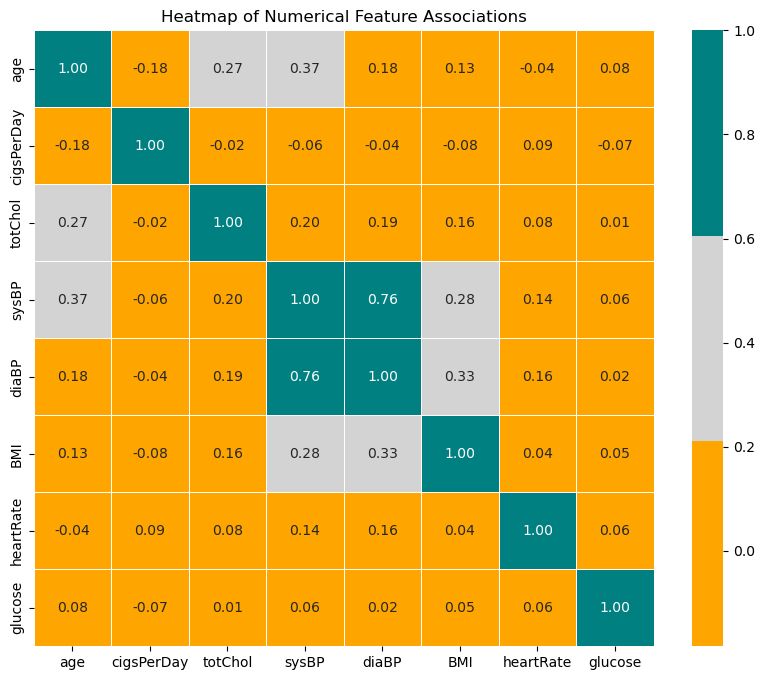

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose
age,1.000000,-0.183239,0.272683,0.370450,0.177990,0.131105,-0.038705,0.077210
cigsPerDay,-0.183239,1.000000,-0.022110,-0.062494,-0.043401,-0.083950,0.089013,-0.070387
totChol,0.272683,-0.022110,1.000000,0.202405,0.186497,0.159296,0.080950,0.009626
sysBP,0.370450,-0.062494,0.202405,1.000000,0.762480,0.277487,0.138699,0.059880
diaBP,0.177990,-0.043401,0.186497,0.762480,1.000000,0.331866,0.156354,0.018517
BMI,0.131105,-0.083950,0.159296,0.277487,0.331866,1.000000,0.037409,0.053284
heartRate,-0.038705,0.089013,0.080950,0.138699,0.156354,0.037409,1.000000,0.061549
glucose,0.077210,-0.070387,0.009626,0.059880,0.018517,0.053284,0.061549,1.000000


In [80]:
#check for any association between independent variables
cleaner.correlation_analysis(columns_cat,df_cleaned)

### Take Aways
#### Exploring Cleaned Data
* There are no nulls and all columns are numerical in df_clean.
* Looking at the figures, the numerical columns like BMI appear to have a more normal distribution now that all the outliers have been removed. 

#### Multicollinearity
* sysBP and diaBP are highly correlated with an association of 0.76
* We need to figure our how to handle this by either ignoring it, dropping a column, or somehow combining the two fields. 

## Addressing Multicollinearity

In [81]:
#Which column is more skewed 
cleaner.compare_skew_between_columns('sysBP', 'diaBP',df_cleaned)

Correlation between 'sysBP' and 'diaBP': 0.76
Skewness of 'sysBP': 0.62
Skewness of 'diaBP': 0.28
→ More skewed column: sysBP


'sysBP'

In [82]:
#sysBP is more skewed so we'll drop this one to avoid multicollinearity
df_cleaned = df_cleaned.drop(columns=['sysBP'])
df_cleaned.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,84.0,23.10,85.0,85.0,0


### Take Aways
#### Handling Multicollinearity
* We decided to see which column was more skewed after all the cleaning we did. The column that is more skewed should be dropped. 
* sysBP was more skewed than diaBP so we decided to drop sysBP

## Standardizing the Data

In [83]:
#do not standardized the encoded categorical variables. This standardizes the others like BMI
df_final = cleaner.scale_numeric_columns(df_cleaned,columns_cat)
df_final

Scaled columns: ['age', 'cigsPerDay', 'totChol', 'diaBP', 'BMI', 'heartRate', 'glucose']


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,-1.185805,4.0,0,-0.784128,0.0,0,0,0,-0.970960,-1.110479,0.452742,0.480969,-0.093079,0
1,0,-0.360052,2.0,0,-0.784128,0.0,0,0,0,0.395394,-0.052844,0.959343,1.857228,-0.194986,0
2,1,-0.124122,1.0,1,0.926587,0.0,0,0,0,0.271180,-0.148992,-0.016439,0.022217,-0.806432,0
3,0,1.409418,3.0,1,1.781944,0.0,0,1,0,-0.225676,1.293237,0.916167,-0.895289,2.556519,1
4,0,-0.360052,3.0,1,1.183194,0.0,0,0,0,1.264892,0.235602,-0.661203,0.939722,0.722182,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4234,1,0.229772,3.0,1,2.893909,0.0,0,0,0,-0.672847,-0.148992,-1.636985,-0.895289,-1.010247,0
4235,0,-0.124122,2.0,1,0.926587,0.0,0,0,0,0.345708,-0.918181,-0.977829,0.847972,0.824090,0
4236,0,-0.595981,1.0,1,0.498908,0.0,0,0,0,-0.598318,0.524048,-1.795298,1.031473,0.008829,0
4238,1,-1.067840,3.0,0,-0.784128,0.0,0,1,0,-1.219388,1.581683,0.058400,-0.711788,-0.602617,0


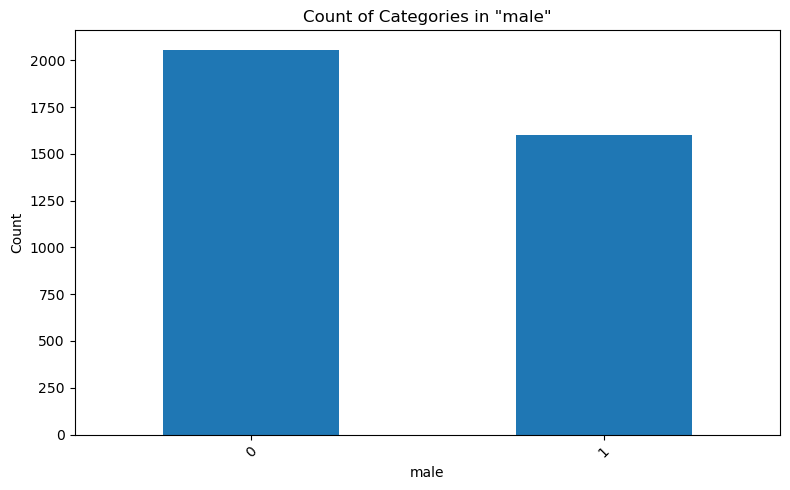

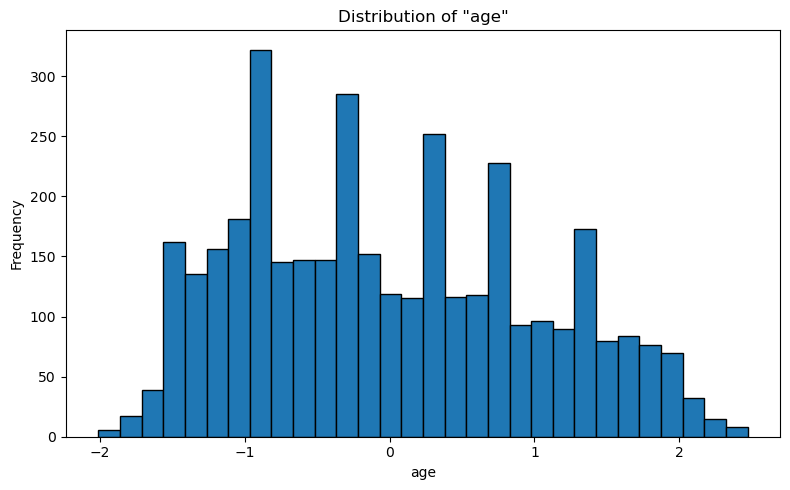

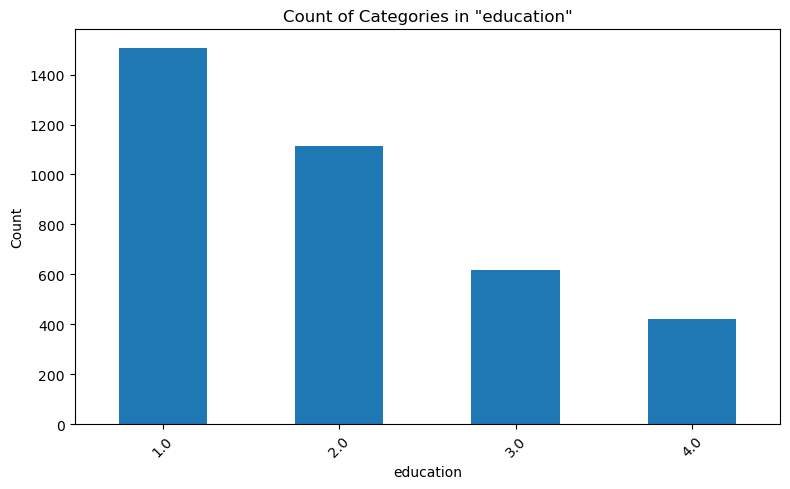

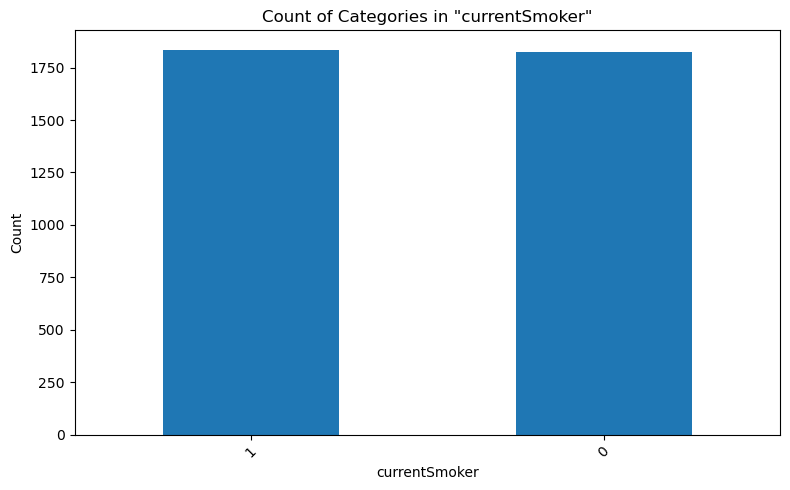

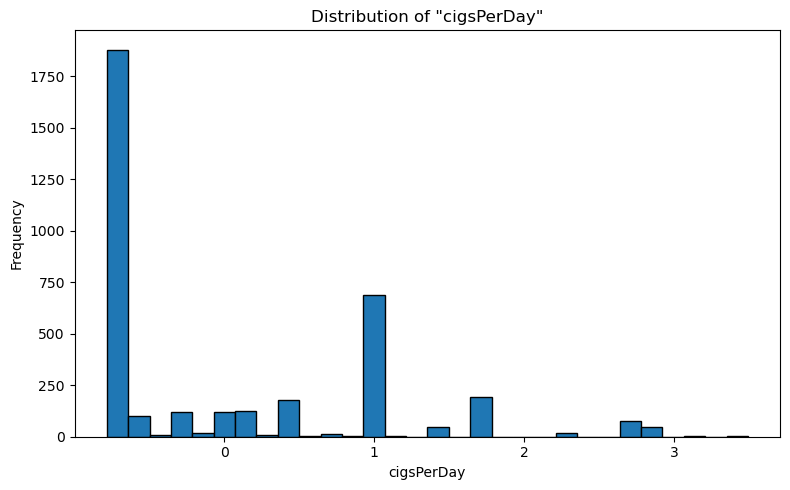

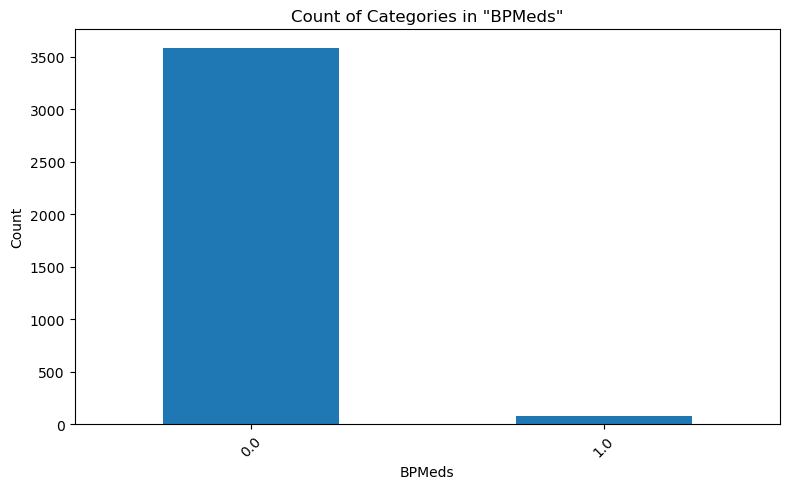

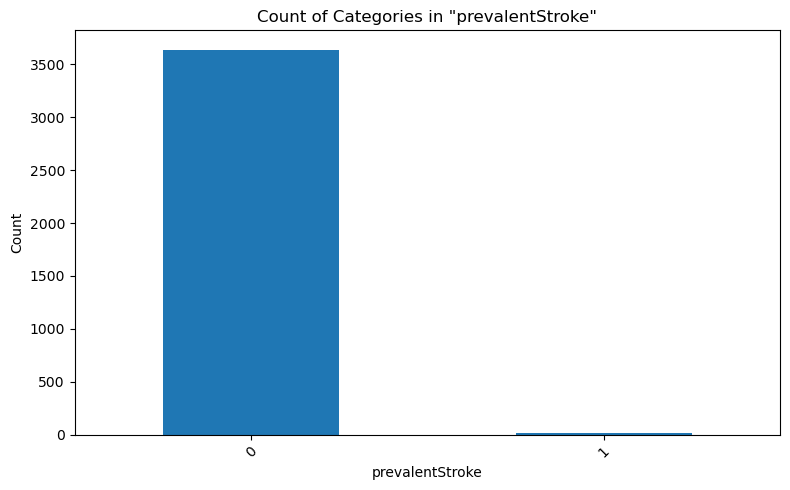

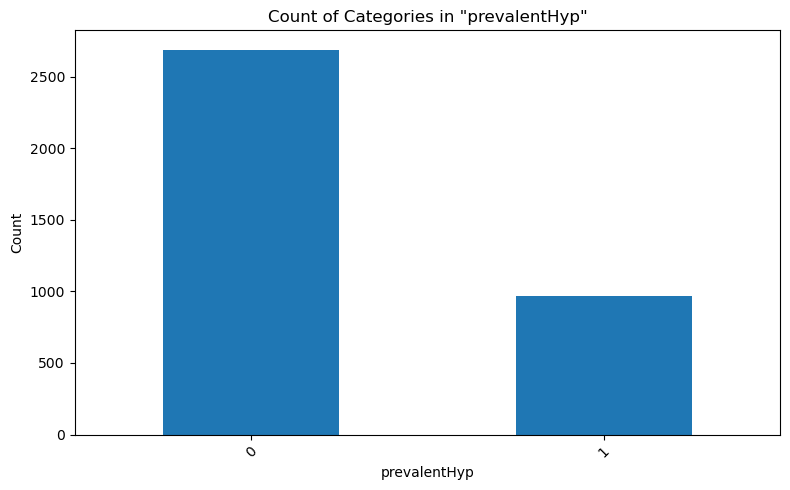

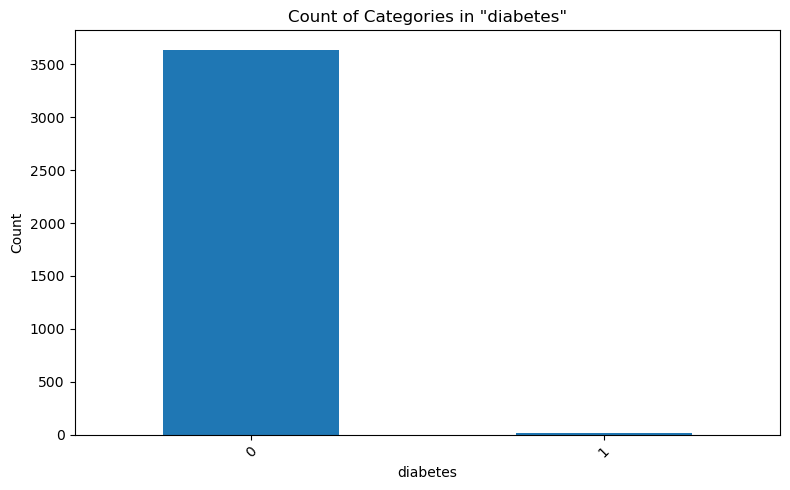

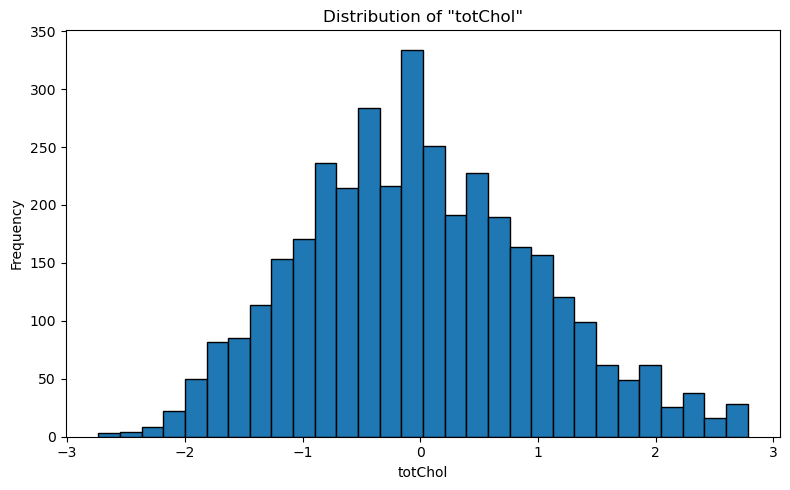

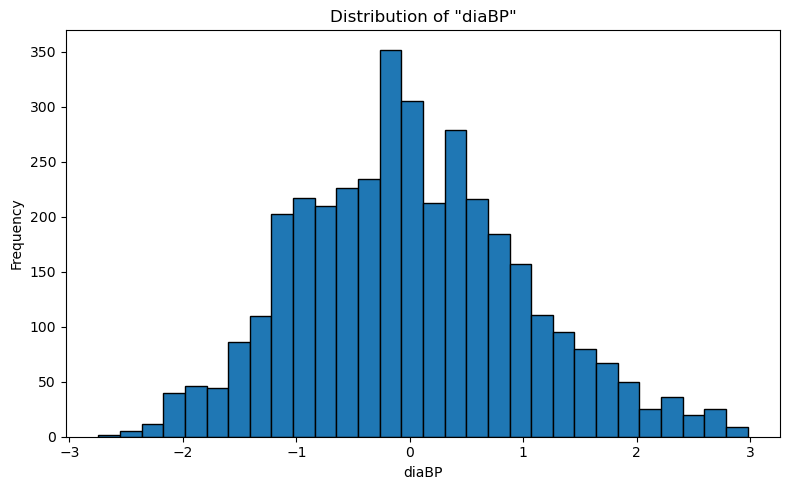

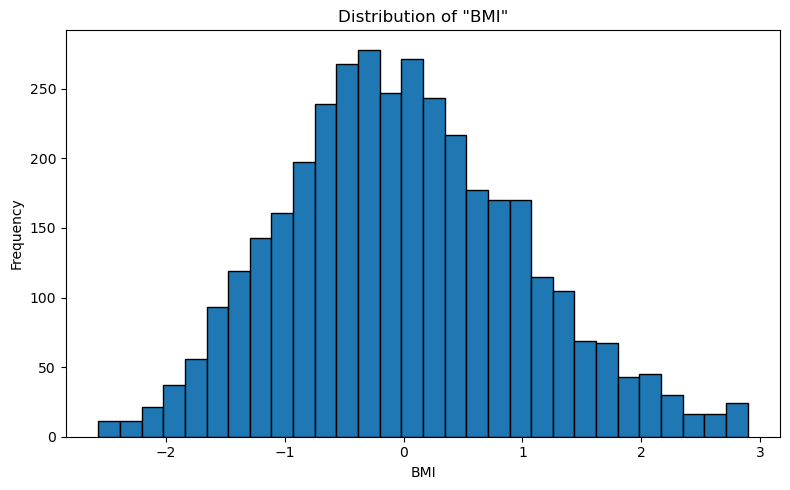

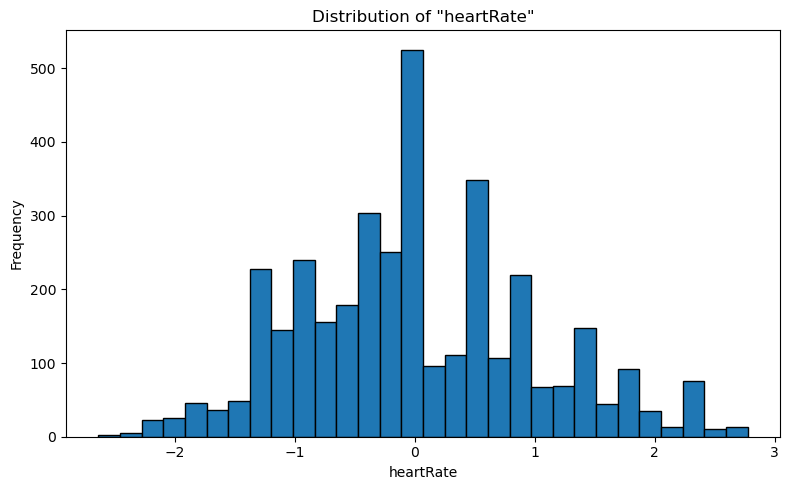

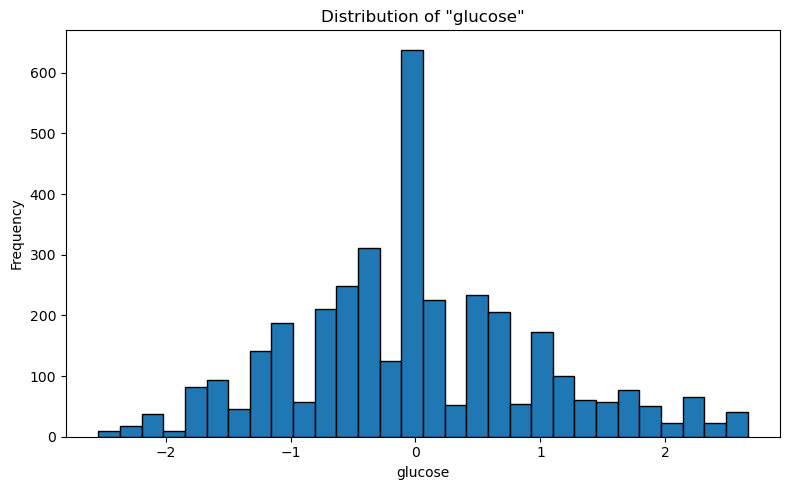

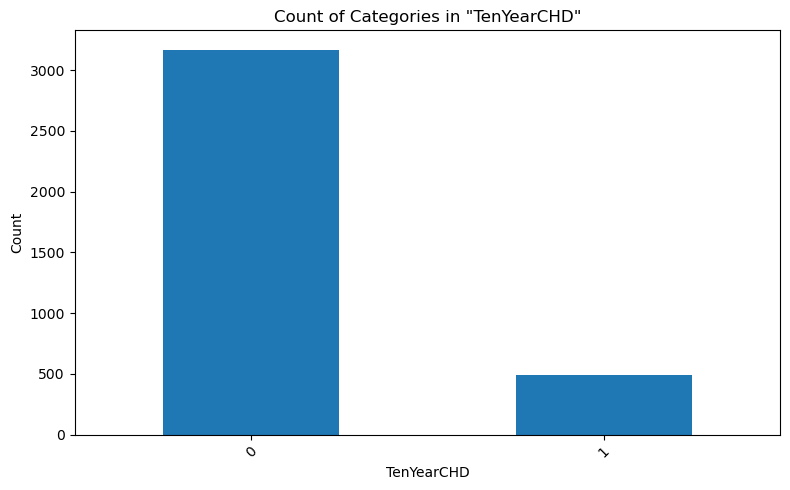

In [84]:
#Taking a look at the standardized fields
cleaner.plot_all_columns(df_final)

### Take Aways
#### Standardizing
* Because all the numerical columns (not counting the categorical fields that became numerical) are on different scale, we used Standard Scaler to standardize the data
* df_final should be used going forward

## <center>  Data Cleaning is now Complete </center>

# Model Preparation

In [85]:
#seperate features and targe
X = df_final.drop('TenYearCHD', axis=1)
y = df_final['TenYearCHD']

In [86]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
#TenYearCHD is heavily imbalanced. Therefore we should implement SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Models

# Logistic Regression - Chris

In [88]:
# Fit the logistic regression model
logit_model = sm.Logit(y_train_resampled, X_train_resampled)
logit_result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.601432
         Iterations 6


In [89]:
# Create a function to run a backwards stepwise regression and document the process
def backwards_stepwise(X, Y, significance_level=0.01):
    logit_features = X.columns.tolist()
    
    # Assume the constant column is named 'const' (check your actual name!)
    intercept = 'const' if 'const' in logit_features else logit_features[0]  # fallback

    while True:
        model = sm.Logit(Y, X[logit_features]).fit(disp=False)
        pvalues = model.pvalues.drop(intercept)  # exclude intercept manually
        max_pval = pvalues.max()

        if max_pval > significance_level:
            excluded_feature = pvalues.idxmax() # Find the name of the column to exclude
            logit_features.remove(excluded_feature) 
            print(f"Dropped '{excluded_feature}' with p={max_pval:.4f}")
        else:
            break

    logit_model = sm.Logit(Y, X[logit_features]).fit(disp=False)
    return logit_model, logit_features

In [90]:
# Run the function and define variables for the output
logit_model, logit_selected_features = backwards_stepwise(X_train_resampled, y_train_resampled, significance_level=0.01)

Dropped 'heartRate' with p=0.8686
Dropped 'prevalentStroke' with p=0.5964
Dropped 'BMI' with p=0.4667
Dropped 'education' with p=0.4932
Dropped 'BPMeds' with p=0.1135
Dropped 'totChol' with p=0.1093
Dropped 'glucose' with p=0.0149
Dropped 'diabetes' with p=0.0149


In [91]:
# Retrivie the probabilities
y_pred_prob_logit = logit_model.predict(X_test[logit_selected_features])

# Convert probabilities to binary predictions
y_pred_logit = (y_pred_prob_logit >= 0.5).astype(int)

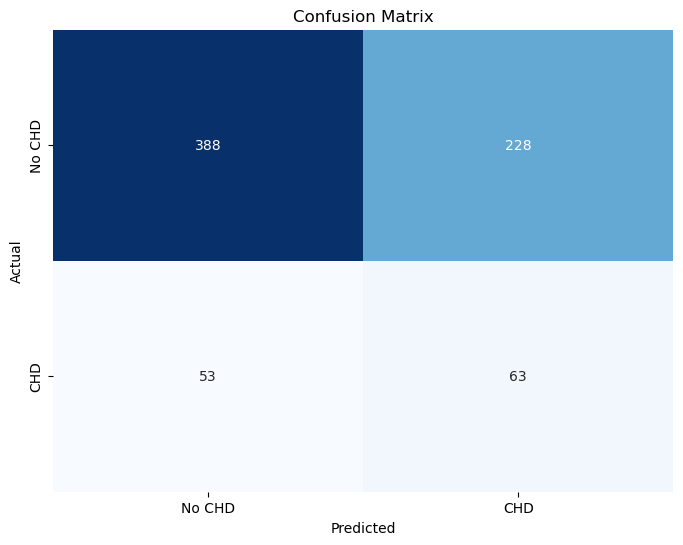

Accuracy: 0.6161202185792349

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.63      0.73       616
           1       0.22      0.54      0.31       116

    accuracy                           0.62       732
   macro avg       0.55      0.59      0.52       732
weighted avg       0.77      0.62      0.67       732



In [92]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_logit)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print accuracy and other metrics
print("Accuracy:", accuracy_score(y_test, y_pred_logit))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logit))

*Conclusion: The model performs very poorly. SMOTE helped to eliminate bias, as the model is predicting risk and no risk at a fairly consistent level, but it struggles to identify patterns for people at risk. Nearly all of the patients that were predicted to be at risk, were not.*

Visualize ROC Curve

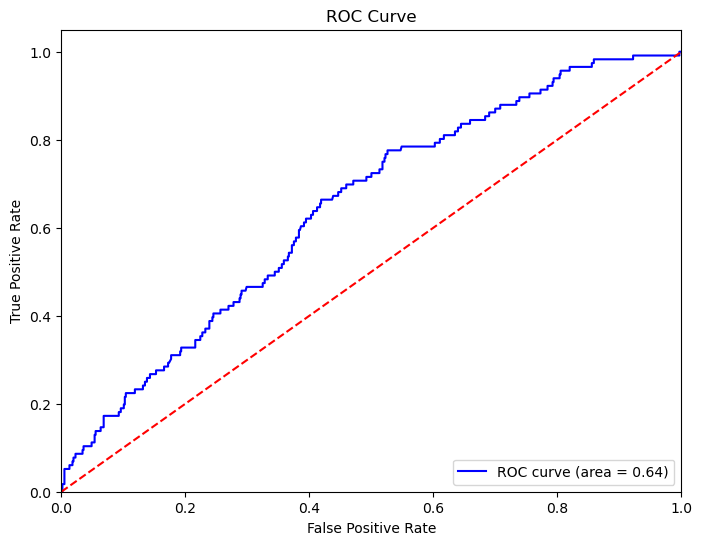

ROC AUC Score: 0.643570868786386


In [93]:
# ROC Curve Visualization
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_logit)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# See the ROC AUC score
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_logit))

*Conclusion: The model is not very good. The ROC curve is close to the 50% line, which in essence says that the model is slightly better than a coin flip. Cross-validation is needed for a deeper understanding of what is going on.*

Use Cross Validation to Check Samples

In [94]:
# Create the logistic regression model
clf = LogisticRegression(random_state=42, max_iter=1000)

# Isolate the selected features for cross-validation
X_selected = X_train_resampled[logit_selected_features]

# Cross-validation
scores = cross_val_score(clf, X_selected, y_train_resampled, cv=5, scoring='accuracy')

# Report the results
print("Cross-validated accuracies:", scores)
print("Average accuracy:", scores.mean())

Cross-validated accuracies: [0.66634051 0.6718903  0.66209598 0.68070519 0.6777669 ]
Average accuracy: 0.671759776589852


*Conclusion: My accuracies vary slightly, confirming that the inaccuarcies in the predictions were not due to a poor sample collected for testing.*

Hyperparameter Tuning

In [95]:
# Grid of hyperparameters to search
param_grid_logit = {
    'C': [0.01, 0.1, 0.5, 0.75, 1, 5, 10, 100, 1000], # regularization strength
    'penalty': ['l2'], # type of penalty
    'solver': ['saga'] # algorithm to use
}

# GridSearch with 5-fold cross-validation
grid_search_logit = GridSearchCV(clf, param_grid_logit, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search_logit.fit(X_train_resampled, y_train_resampled)

# Best parameters and score
print("Best hyperparameters:", grid_search_logit.best_params_)
print("Best cross-validated accuracy:", grid_search_logit.best_score_)

c:\Users\Chris Napoli\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validated accuracy: 0.6762655468047711


*I tested all possible combinations of penalty and solver and chose the best one. My results from all tested options are below*
1. *l1 and liblinear accuracy = 0.6761*
2. *l2 and liblinear accuracy = 0.6759*
3. *l2 and newton-cg accuracy = 0.6763*
4. *l2 and lbfgs accuracy = 0.6761*
5. *l2 and sag accuracy = 0.6761*
6. *l2 and saga accuracy = 0.6763*
7. *l1 and saga accuracy = 0.6759*
8. *None and newton-cg accuracy = 0.6757*
9. *None and lbfgs accuracy = 0.6761*
10. *None and sag accuracy = 0.6757*
11. *None and saga accuracy = 0.6757*

In [96]:
# Create new model with best parameters
best_logit_model = grid_search_logit.best_estimator_

# Get new predictions and probabilities based on new parameters
y_pred_logit = grid_search_logit.best_estimator_.predict(X_test)
y_prob_logit = grid_search_logit.best_estimator_.predict_proba(X_test)[:, 1]

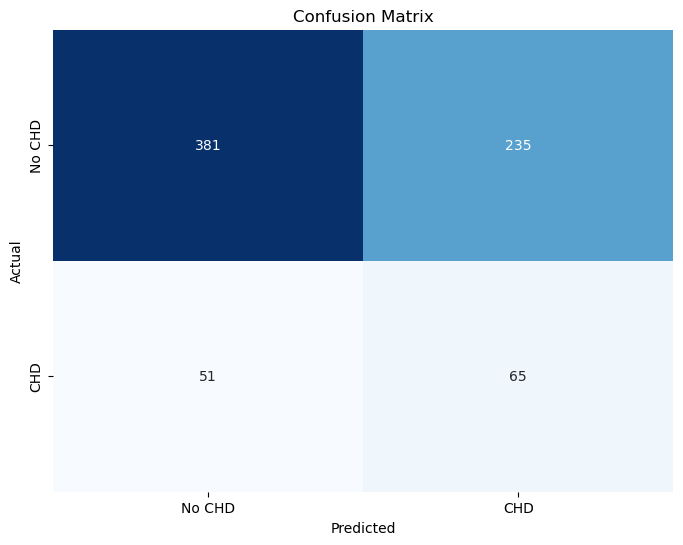

Accuracy: 0.6092896174863388

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.62      0.73       616
           1       0.22      0.56      0.31       116

    accuracy                           0.61       732
   macro avg       0.55      0.59      0.52       732
weighted avg       0.78      0.61      0.66       732



In [97]:
# Generate the confusion matrix
cm_tuned = confusion_matrix(y_test, y_pred_logit)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print accuracy and other metrics
print("Accuracy:", accuracy_score(y_test, y_pred_logit))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logit))

*Conclusion: Very similar results prior to hyperparameter tuning. Seems as though the parameters had minimal impact on the model's performance.*

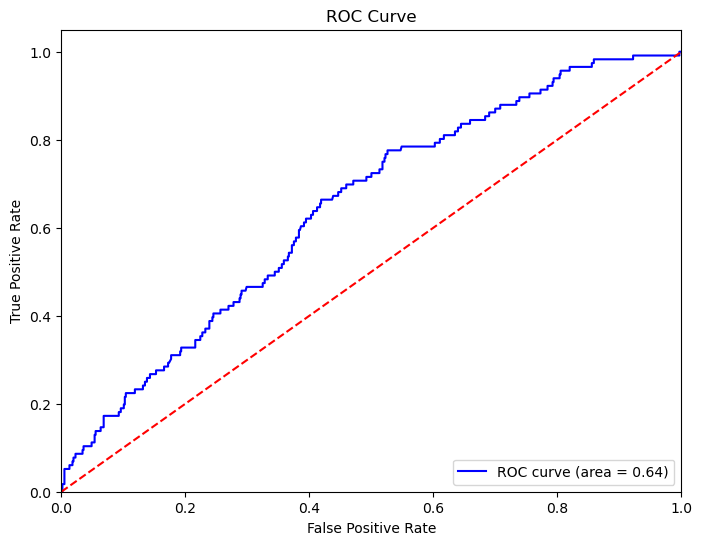

ROC AUC Score: 0.643570868786386


In [98]:
# Create variables for the ROC curve
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_pred_prob_logit) # y_pred_prob
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# ROC Curve Visualization
plt.figure(figsize=(8, 6))
plt.plot(fpr_tuned, tpr_tuned, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_tuned)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# See the ROC AUC score
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_logit))

*Conclusion: Using hyperparameter tuning, my model's performance increase very slightly. My precision and recall improved slightly, but not nearly enough to make logistic regression a usable model to predict coronary heart disease in 10 years. My ROC curve also had no change at all. Overall, with my best model having a precision of ≈22% and a recall of ≈56%, I would advise not to use this model for predictive purposes.*